In [180]:
# "Проверка гипотезы: На выходных (суббота и воскоресенье) обычно падает курс"

In [181]:
from get_data import get_polo_data
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics 
from sklearn import svm
from pandas import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [182]:
# Беру статистику за 2000 дней 
sd = get_polo_data(pair="USDT_BTC", frame=(2000+1)*60*60*24,zoom='1D')
# Скачалось чуть меньше 2000 дней, ну да ладно
print(len(sd))
print(len(sd)-len(sd.dropna()))

DEBUG:poloniex:Getting 2019-11-24 13:30:00 - 2019-11-24 13:38:14 USDT_BTC candles from Poloniex...
DEBUG:poloniex:Updating USDT_BTC database with 2 entrys...
100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 111.11it/s]
DEBUG:poloniex:Getting USDT_BTC chart data from db


1740
0


In [183]:
# Заполняю столбец. Если курс вырос, то 1. Если нет, то '-1' 
sd["delta"]=sd["close"]-sd["open"]
sd["isgrowing"]=sd['delta'].map(lambda delta: math.copysign(1, delta ))
# Заполняю столбец День недели 
sd['WeekDay'] = sd.index
sd['WeekDay'] = sd['WeekDay'].dt.weekday_name
sd['WeekDayNmb'] = sd.index
sd['WeekDayNmb'] = sd['WeekDayNmb'].dt.weekday

In [184]:
# # Это просто построил график. Посмотреть на распределение   
# (sd['close']-sd['open']).hist(bins=10)

In [185]:
# # Это тоже график. Напосмотреть себе
# sd['open'].plot(fontsize=14)

In [186]:
# # Теперь создаю новый Dataframe. По правилам.А ты как делаешь? 
# target_features=['isgrowing']
# nominal_features=['WeekDay']

In [187]:
# data_nom=sd[nominal_features]
# data_nom_dum=pd.get_dummies(data_nom)
# data_target=sd[target_features]
# data_my=pd.concat([data_nom_dum,data_target],axis=1)

In [188]:
# # Строю корреляционную  матрицу
# sns.set(font_scale=2.5)
# plt.figure(figsize=(40,30))
# corr_matrix=data_my.corr()
# sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True,cmap='PuOr',annot_kws={"size":14})

In [189]:
# # Судя по результатам, никакой связи нет. Везде значения меньше 0.1 
# # Но может быть в воскресенье, и то цена не падает, а растет. Вроде так??? 
# for i in corr_matrix:
#     print(i, corr_matrix[i]['isgrowing'])

In [190]:
# # Ок. А может изменить гипотезу. Зависит ли разница между открытием и закрытием от дня недели.
# # Добавляем в frame  еще один столбец delta 
# data_my['delta']=sd['delta']

In [191]:
# sns.set(font_scale=2.5)
# plt.figure(figsize=(40,30))
# corr_matrix=data_my.corr()
# sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True,cmap='PuOr',annot_kws={"size":14})

In [192]:
# # Похоже что не фига не зависит. Как-то так?  
# for i in corr_matrix:
#     print(i, corr_matrix[i]['delta'])

In [193]:
# ДОБАВИЛ НУЛЕВОЙ СТОЛБЕЦ И УБРАЛ ВСЕ ДНИ КРОМЕ СУББ И ВОСКР
sd['empty']=0
sd = sd.query("WeekDayNmb  in [5,6]")
train=sd[['WeekDayNmb','empty']]
target=sd['isgrowing']
train_parm, test_parm, train_indic, test_indic = model_selection.train_test_split(
    train, target, test_size = 0.3, random_state = 0)

In [194]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC()

In [195]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

kfold=5
itog_val = {}
scores = cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_val_score(model_lr, train, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVC'] = scores.mean()

0.5803265306122449
0.42367346938775513
0.5803265306122449
0.5803265306122449


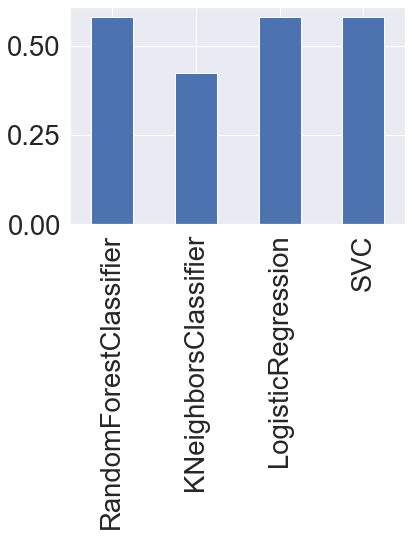

In [196]:
for i in itog_val: 
    print (itog_val[i])
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

In [197]:
# УЖЕ ЛУЧШЕ. А ЧТО ЕСЛИ УБРАТЬ ВОСКРЕСЕНЬЕ. 
print ("Строк изначально",sd['open'].count())
sd = sd.query("WeekDayNmb  in [5]")
print ("Убрал день",sd['open'].count())
train=sd[['WeekDayNmb','empty']]
target=sd['isgrowing']
train_parm, test_parm, train_indic, test_indic = model_selection.train_test_split(
    train, target, test_size = 0.3, random_state = 0)

Строк изначально 498
Убрал день 249


In [198]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC()

In [199]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

kfold=5
itog_val = {}
scores = cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_val_score(model_lr, train, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVC'] = scores.mean()


0.6024489795918366
0.39755102040816326
0.6024489795918366
0.6024489795918366


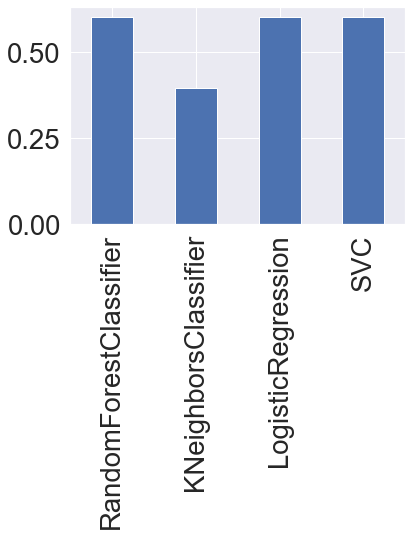

In [204]:
for i in itog_val: 
    print (itog_val[i])
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

In [ ]:
# Получается что в субботу с вероятностью 0,6 курс будет падать. Как-то так 

In [203]:
# model_rfc.fit(train_parm, train_indic)
# model_lr.fit(train_parm, train_indic) 
# model_svc.fit(train_parm, train_indic)
# model_knc.fit(train_parm, train_indic)


# y_predicted = model_rfc.predict(test_parm)
# print(metrics.classification_report(test_indic, y_predicted))
# y_predicted = model_lr.predict(test_parm)
# y_predicted = model_svc.predict(test_parm)
# y_predicted = model_knc.predict(test_parm)


In [202]:
# model_rfc.score(test_parm, test_indic)
# # print(metrics.classification_report(test_indic, y_predicted))
# # print(metrics.classification_report(test_indic, y_predicted))
# # print(metrics.classification_report(test_indic, y_predicted))
# # print(metrics.classification_report(test_indic, y_predicted))
